# Movie Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this article you will analyze a dataset of movie ratings. You will learn about:

1. Getting and Cleaning the Data
2. Getting the overall figures and basic statistics with their interpretation
3. Joining datasets, aggregating and filtering your data by conditions
4. Discovering hidden patterns and insights
5. Creating summary tables

You will achieve all of it by using Python and its popular <a href="https://pandas.pydata.org/docs/getting_started/index.html#getting-started" target="_blank">`pandas`</a>  and <a href="https://matplotlib.org/3.2.2/contents.html" target="_blank">`matplotlib`</a> libraries. You can download and run the Jupyter Notebook that this article is based on **here**.

## Introduction

You can access the code of the <a href="https://github.com/sidooms/MovieTweetings" target="_blank">Movie Tweetings Project</a> that you will be working with on GitHub. Here is what the project is about in a nutshell:

It consists of ratings of movies that were contained in well-structured tweets on Twitter and it has been updated every day since 2013. OK, but how is this data created?

It comes from people who connected their <a href='https://www.imdb.com/' target='_blank'>IMDB</a> profile with their <a href='https://twitter.com/' target='_blank'>Twitter</a> accounts. Whenever they rate a movie on the IMDB website an automated process will shoot a tweet.

And these *well-structured* tweets look like this:

>"I rated The Matrix 9/10 http://www.imdb.com/title/tt0133093/ #IMDb"

Nice, but can you use this data to learn and practice some data analysis using Python? The answer is yes!

You are highly encouraged to write the code for this project yourself. You may discover some additional interesting revelations in the data, and doing the work yourself is what will give you the practice you need to improve your skills.

You can either download the data from the original repo or from <a href="https://drive.google.com/drive/folders/1nSV5S8jCh7LbrTdIgOSyxq6DqN-G3bah?usp=sharing" target="_blank">here</a>. Note that you will have the most up to date data if you use the original repo.

## Inspect the Data

To get started, confirm that you have these 3 files in your working directory:

- `users.dat`
- `movies.dat`
- `ratings.dat`

If all these files are accessible to you, you can start off your investigation by checking what these files contain. Let's start off by looking at the first three lines in `users.dat` directly in your terminal:

In [2]:
%%bash
head -n3 '/content/drive/MyDrive/Colab Notebooks/MoviesData/data/users.dat'

1::139564917
2::522540374
3::475571186


At first it may be confusing that you can't see any field names but these are documented in the <a href="https://github.com/sidooms/MovieTweetings" target="_blank">README</a> file as follows:

>In `users.dat` the _first_ field is the `user_id` and the _second_ one is `twitter_id`.

You can see that there is a surprising amount of colons in this data snippet. Because you already know that you are working with two data fields, this means that the creators of this dataset decided to use a double-colon `::` as a field separator. Interesting choice! It is helpful to keep in mind that data fields can be divided by all sorts of different separators, and it's good to know which one is used in the data you are working with.

With a basic idea of what you can expect to see in `users.dat`, let's next take a peek into `movies.dat`:

In [3]:
%%bash
head -n3 '/content/drive/MyDrive/Colab Notebooks/MoviesData/data/movies.dat'

0000008::Edison Kinetoscopic Record of a Sneeze (1894)::Documentary|Short
0000010::La sortie des usines Lumière (1895)::Documentary|Short
0000012::The Arrival of a Train (1896)::Documentary|Short


In this file, you have three fields:

1. `movie_id`
2. `movie_title`
3. `genres`

A single movie can belong to more than one genre, and the `genres` are separated by pipe characters `|`, another interesting choice!

After looking at `movies.dat`, there's only one file left to inspect. Let's peek into `ratings.dat` next:

In [4]:
%%bash
head -n3 '/content/drive/MyDrive/Colab Notebooks/MoviesData/data/ratings.dat'

1::0114508::8::1381006850
2::0102926::9::1590148016
2::0208092::5::1586466072


In this third dataset, your variables are:

1. `user_id`
2. `movie_id`
3. `rating` and
4. `rating_timestamp`

And again it comes with an interesting feature: The timestamps are in <a href="https://www.unixtimestamp.com/" target="_blank">unixtime</a> format!

**UNIX time** is a time format often used in computer time that shows the seconds passed since January 1st, 1970. You can use online converters to translate it to a format that is easier to read for humans. If you're interested, read more about <a href='https://en.wikipedia.org/wiki/Unix_time' target='_blank'>Unix time on Wikipedia</a>.

## Set Up Your Notebook
    
Now you have an overall understanding of how the raw datasets look like. Next, you will import the libraries you will need for the rest of this analysis:

In [5]:
import warnings

import pandas as pd
import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore')

Let's look a bit closer at the options you set up in the code snippet above. You:

- Give the `filter-out-warnings` command to have a cleaner notebook without warning messages
- Set the max rows and max columns to some big numbers, in this case `50`. This option just makes all the columns and rows in a DataFrame more readable or visible
- Use `fivethirtyeight` style to have plots like the ones on <a href="https://www.fivethirtyeight.com" target="_blank">fivethirtyeight.com</a>: A website founded by <a href="https://en.wikipedia.org/wiki/Nate_Silver" target="_blank">Nate Silver</a>. If you want to explore `fivethirtyeight` further, I highly recommend the book: <a href="https://www.amazon.com/Signal-Noise-Many-Predictions-Fail-but/dp/0143125087" target="_blank">The Signal and the Noise</a>

These imports and adjustments create a good base setup for you to get started with your analysis. Keep in mind that while the `import`s are necessary, the adjustments are just to make your analysis easier and better-looking.

## Read in the Data

After importing the necessary libraries, you are now ready to read the files into `pandas` data frames.

There are a couple of adjustments you should make while reading in the data, to make sure it will be in good shape to work with:

- Define that the separators are double colons `::`
- Give the column names when so they will become the headers
- Convert the UNIX time to a datetime format

With this in mind, let's read in `users.dat`, `ratings.dat` and `movies.dat` one by one:

### Users: `users.dat`

Starting with `users.dat`, the following code snippet will read in the file into your notebook, register the double-colon as the separator between the fields, and add column names as well:

In [6]:
import pandas as pd
import os

# Set the global path to your MoviesData folder
GLOBAL_PATH = '/content/drive/MyDrive/Colab Notebooks/MoviesData/'

# Create a helper function to build full file paths
def get_file_path(filename):
    return os.path.join(GLOBAL_PATH, filename)

In [7]:
users = pd.read_csv(get_file_path('data/users.dat'), sep='::',
                    names=['user_id', 'twitter_id'])


This creates a `DataFrame()` object, and you can check the first few entries of this table-like object with the `.head()` method:

You will see a nicely formatted output that shows the first 5 rows of your `users` data frame:

In [8]:
users.head()

,user_id,twitter_id
0,1,139564917
1,2,522540374
2,3,475571186
3,4,215022153
4,5,349681331


You successfully read in the data from the external file and now have access to it as a `DataFrame()` object. Let's do the same with the other files as well.

### Ratings: `ratings.dat`

Similar to before, you will want to read in the data and save it into a data frame, define the separator, and pass in the column names. Additionally, you will also call the `.sort_values()` method on the data frame right away, to sort your data by when the ratings have been created:

In [9]:
ratings = pd.read_csv(get_file_path('data/ratings.dat'), sep='::',
                      names=['user_id', 'movie_id', 'rating', 'rating_timestamp']
                      ).sort_values("rating_timestamp") # sorting the dataframe by datetime

You will also want to convert the `rating_timestamp` values to actual `datetime` format, and you can do that in `pandas` like so:

In [10]:
ratings["rating_timestamp"] = pd.to_datetime(ratings["rating_timestamp"], unit='s')

Let's peek into the first 5 rows of your newly created `ratings` data frame.

Your output should look similar to below:

In [11]:
ratings.head()

,user_id,movie_id,rating,rating_timestamp
138461,11080,2171847,6,2013-02-28 14:38:27
585269,45890,444778,8,2013-02-28 14:43:44
611517,47821,1411238,6,2013-02-28 14:47:18
648464,50454,1496422,7,2013-02-28 14:58:23
742847,58297,118799,5,2013-02-28 15:00:53


With the `ratings` data read in, there's only one more file left to go.

### Movies: `movies.dat`

Of course you also need to have access to information about the actual movies, to find potential correlations e.g. between ratings and movie genres. So, let's read in that data next:

In [12]:
movies = pd.read_csv(get_file_path('data/movies.dat'), sep='::',
                     header=None, names=['movie_id', 'movie_title', 'genres']);

Checking the successful completion of this process with the familiar `movies.head()` command, you will see something similar to below:

In [13]:
movies.head()

,movie_id,movie_title,genres
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,10,La sortie des usines Lumière (1895),Documentary|Short
2,12,The Arrival of a Train (1896),Documentary|Short
3,25,The Oxford and Cambridge University Boat Race ...,NaN
4,91,Le manoir du diable (1896),Short|Horror


With this you're all set and the data has been read in to the notebook. What follows next, is **exploration**.

## Explore Your Data

To get a feeling for the data you are working with, it always helps to play around a little and create some quick stats and graphs for different aspects of it. This will help you have a better overview of what the data is about.

Since you want to find out how well movies are liked or disliked, the most important variable is the movie `rating`. Let's see its distribution:

In [14]:
ratings['rating'].value_counts()

,count
rating,
8,211699
7,196410
9,124459
6,114372
10,103648
5,65907
4,26940
3,14759
1,10324


`value_counts()` is a quick but effective way of checking what values your variable takes. Here we see quickly that the rating score `8` was given `211699` times!

Let's keep exploring. A **histogram** will show you the distribution and the `describe()` method will give additional **basic statistics**. Both of them are quite helpful to get quick insights, so let's try them out next:

In [15]:
ratings['rating'].describe()

,rating
count,877563.000000
mean,7.316577
std,1.853619
min,0.000000
25%,6.000000
50%,8.000000
75%,9.000000
max,10.000000


As mentioned, the `.describe()` method will display basic statistics about a column, so here they are for the `rating` column.

Next, let's look at a visual representation of the data by creating a histogram. The data with the above settings will produce a histogram that looks like below:

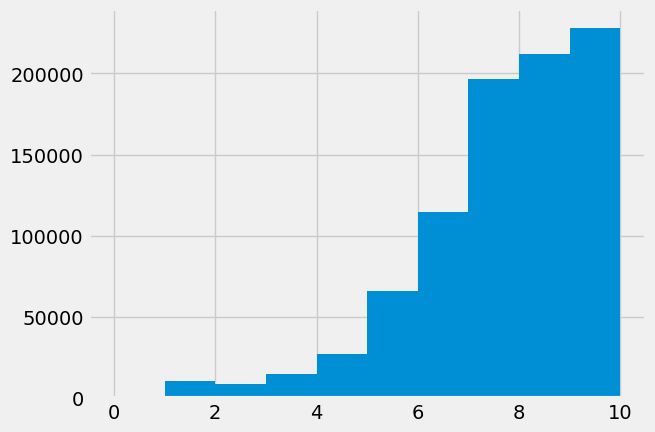

In [16]:
ratings['rating'].hist(bins=10);

It is skewed to the left! That means that the distribution doesn't have a symmetrical shape around the mean and this specific off-balanced distribution has a long tail on the left hand side.

The `hist()` and `describe()` methods are in fact quite similar: One gives text output and the other gives its visual representation.

Given that both functions return the same output, you may also be able to conclude that the `rating` is left-skewed by looking only at the text output of your `.describe()` method. The relevant data for this conclusion are:

* The `mean` is much smaller than the `median` and
* 25% of the data covers only until a rating of `6`

This is a bit confusing. You have seen first that the highest frequency was `8`. And then, after generating the histogram, it looked like the ratings were highest around `9`-`10`.

This difference can arise because of <a href="https://statistics.laerd.com/statistical-guides/understanding-histograms.php" target="_blank">binning</a>! Different amounts of bins will lead to different results. Most of the time, the person conducting the analysis decides the right number of bins after a few trials. Generally, you will have a better idea about what is the right bin size for your data set after some research and digging into it.

Playing with the bins of a histogram can have an impact on the story you are telling. The same histogram would look like this if you increase the number of bins from `10` to `30`:

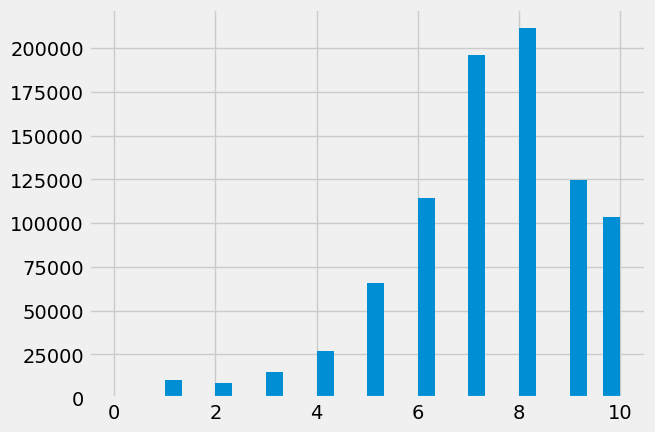

In [17]:
ratings['rating'].hist(bins=30);

You can see that this can lead to a different conclusion. If you were using the _first_ histogram you would falsely argue that the most frequent rating was `9` or maybe `10`. However, the _second_ one makes everything crystal clear and shows that the most frequent rating lies at `8` instead. Also, note that if you use the `.value_counts()` method, you wouldn't fall into that trap.

Thanks to these methods now you have a more clear understanding about the `rating` variable in your data. You will focus on the `user_id` column next.

How many unique `user_id` do you have in the `users` data?

In [18]:
f"We have {len(users.user_id.unique())} unique user ids in the data"

'We have 68388 unique user ids in the data'

>'You have 68388 unique user ids in the data'

You have seen earlier that both `value_counts()` and `describe()` are quite handy. So why not combine them to learn a little more?

For instance, how many rating tweets are posted by a user on average? What is the minimum, maximum and median number of tweets posted by the users? The answer to these questions will enable you understand how active the users are: Are they frequent users or are they disappearing after shooting one single tweet? Let's try it out:

In [19]:
ratings.user_id.value_counts().describe()

,count
count,68388.000000
mean,12.832120
std,46.009589
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,2875.000000


Running the code snippet above, you will receive another block of text-based statistics as your output.

Notice that this time above you accessed the column using **dot notation**, which in this case does the same as accessing it through the square-bracket notation you used before, but is a little bit more convenient. Check out <a href='https://stackoverflow.com/a/55057329' target='_blank'>this StackOverflow post</a> if you want to learn more about the limitations and differences between the two notations.

See in the above output how the `mean` is much greater than the `median` (12.83 vs 2). It means that the data is skewed to the right.

This skewness is at the extreme: Look how the `max` value is far far away! Could there be someone posting more than 2000 times? Not likely.

The output also tells us that _50%_ of the people used it only _twice_ but the `mean` is almost `13`. This is because of those users with extremely high usage numbers. Could it be possible that they are not human beings but bots instead? That could be a great investigation topic, if you want to dive deeper. However, in this article you will leave this aside for now and continue by joining the datasets you have.

## Join the Datasets

Joining data could be really difficult, as this tweet addresses:

![Joining before Pandas Twitter](https://github.com/CodingNomads/articles/blob/main/movie-tweets/imgs/tweet_pandas.PNG?raw=true)

Luckily, with `pandas` you have a user-friendly interface to <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html" target="_blank">join</a> your `movies` data frame with the `ratings` data frame. This is going to be an *inner* join. It means that you are bringing in the movies only if there is a rating available for them:

In [20]:
movies_rating = (ratings
                  .set_index("movie_id")
                  .join(movies.set_index("movie_id"),
                        how="left")
                 )

movies_rating.head(2)

,user_id,rating,rating_timestamp,movie_title,genres
movie_id,,,,,
2171847,11080,6,2013-02-28 14:38:27,Dead Mine (2012),Action|Horror
444778,45890,8,2013-02-28 14:43:44,Mah nakorn (2004),Comedy|Fantasy|Romance


Inspecting the first two rows with the `.head(2)` method showed you this output.

Notice that you didn't use the `on` and `how` parameters when you joined the data, because you set the index of both data frames to `movie_id`. So, the `.join()` method knew on which variable to join and by default this creates an *inner* join.

Looking at the output of the `.join()` operation, you have a new problem: You want to quantify the _genres_, but how would you count them?

One way of doing that could be creating dummies for each possible `genre`, such as _Sci-Fi_ or _Drama_, and having a single column for each. Creating dummies means creating `0`s and `1`s just like you can see in the example below:

In [21]:
dummies = movies_rating['genres'].str.get_dummies()

The data frame that gets produced by this command looks like below:

In [22]:
dummies.head()

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2171847,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
444778,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1411238,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1496422,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
118799,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


You can concatenate these `dummies` to the original `movies_rating` data frame:

In [23]:
tidy_movie_ratings = (pd.concat([movies_rating, dummies], axis=1)
                       .drop(["rating_timestamp", "genres"], axis=1)
                )

Your newly created data frame will look like this:

In [24]:
tidy_movie_ratings.head()

,user_id,rating,movie_title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2171847,11080,6,Dead Mine (2012),1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
444778,45890,8,Mah nakorn (2004),0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1411238,47821,6,No Strings Attached (2011),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1496422,50454,7,The Paperboy (2012),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
118799,58297,5,La vita è bella (1997),0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


This is almost as tidy as you want it, but it would be much more clean and useful if you could get those production years in a separate column. That would allow you to compare film productions over the years.

To accomplish this, you will practice working with the `.str` attribute, which is quite popular and a lifesaver in many cases. You will:

- Make a new column by getting the 4 digits representing the year
- Remove the last 7 characters from the movie names
- Checkout the result

Let's write the code for achieving these tasks:

In [25]:
tidy_movie_ratings["production_year"] = tidy_movie_ratings["movie_title"].str[-5:-1]
tidy_movie_ratings["movie_title"] = tidy_movie_ratings["movie_title"].str[:-7]

Before checking out the results, let's go ahead and reset the index on this data frame first:

In [26]:
tidy_movie_ratings.reset_index(inplace=True)

Now you can see that you produces a better-formatted version of the data frame:

In [27]:
tidy_movie_ratings.head(2)

,movie_id,user_id,rating,movie_title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western,production_year
0,2171847,11080,6,Dead Mine,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2012
1,444778,45890,8,Mah nakorn,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2004


**Congratulations!** With this, you have completed the most difficult part: Getting and cleaning the data. Let's quickly recap what you did so far:

- You read the raw data into data frames
- You learnt and reported basic statistics
- You joined data frames and created new fields
    
This was not easy. You did some great work if you followed all the way until here. You can now: <a href="https://www.youtube.com/watch?v=2wnOpDWSbyw" target="_blank">watch the first movie in your records from 1894</a> as a reward :)

Next, you are going to visualize your data and discover some patterns. Generally this part is more interesting for most people when you deliver your report.

## Visualize Patterns

You will start with visualizing the total volume of films created over the years.

You will count the total number of productions for each year and plot it. The record you see for the year of 2021 should be filtered out before proceeding:

In [28]:
condition = tidy_movie_ratings["production_year"].astype(int) < 2021

prodcount = (tidy_movie_ratings[condition][["production_year", "movie_id"]]
             .groupby("production_year")
             .count()
            )

Similar to the `.head()` method you have encountered before, `.tail()` shows you a subset of the rows of your data frame. However, instead of showing the _first_ ones, it shows you the _last_ ones:

In [29]:
prodcount.tail()

,movie_id
production_year,
2016,80425
2017,62035
2018,43694
2019,50044
2020,5712


Aside from 2021, which you filtered out, the other interesting year here is 2020. Although more than half of the year 2020 has passed at the time of writing this article, there are only `5712` rated films and movies for the year so far. Looks like 2020 is one of the most extraordinary years in history? Or maybe the movies are so new, that people didn't have the time to watch them yet. Or both!

You can chart a 5 year moving average of the total productions:

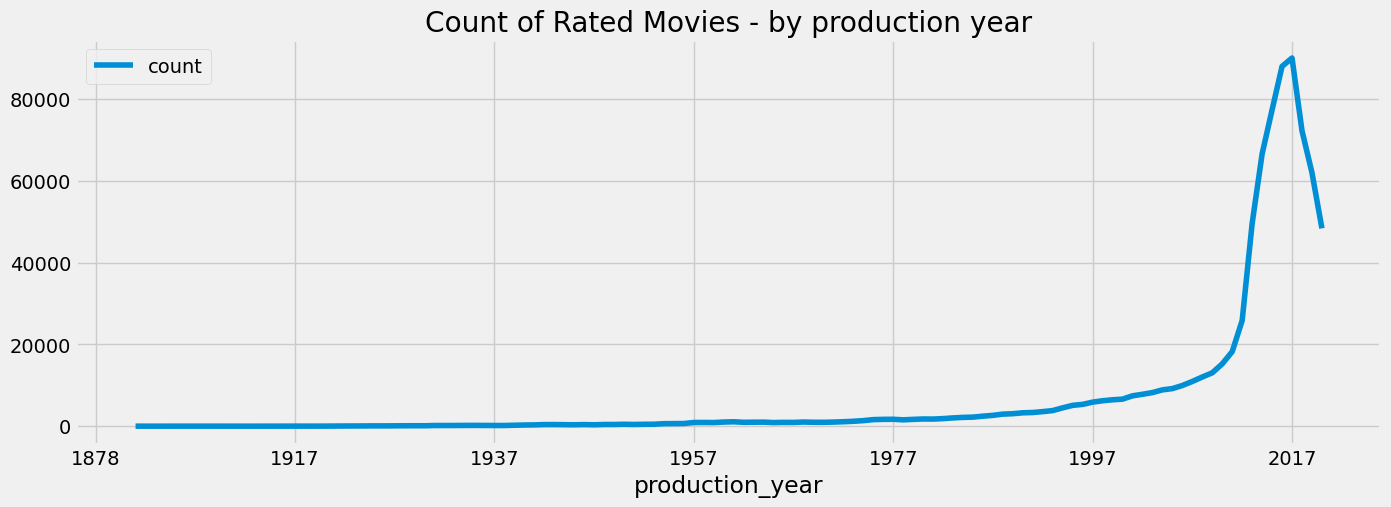

In [30]:
(prodcount
 .rolling(5).mean().rename(columns={"movie_id":"count"})
 .plot(figsize=(15,5),
       title="Count of Rated Movies - by production year")
);

You can see that the 5-year moving average is in a shocking decline! What is happening here? What can be the reason? Can you formulate some hypotheses? Here are some points for you to consider:

- This was an *inner* join. So these are the _rated_ movies. Perhaps site and app usage went down.
- The filming industry is in a serious crisis! They are not producing films because of COVID-19.
- The people didn't have the time to watch the most recent movies. If they didn't watch them, they don't rate them, and you can see a decline in ratings. For example, I didn't watch the _Avengers_ series before doing this analysis. On the other hand, the movie _Braveheart_ (1995) most probably had enough time to get high numbers.

Each of these hypotheses could warrant an investigation, and there might be other ideas that you can come up with yourself. Feel free to explore any of these hypotheses further on your own and remember that practicing your skills by following your interest is one of the best ways to learn new skills and keep them sharp.

For this article, let's continue by investigating a slightly different question:

>What have people watched (or rated) most since 2000?

## Explore a Question

For this question, let's focus on the genres with a high volume of movies. You are going to identify the top 6 genres with the highest number of movies in them, and filter them out to produce the next chart:

In [31]:
top6_genre = (tidy_movie_ratings.iloc[:, 4:-1] # get the genre columns only
              .sum() # sum them up
              .sort_values(ascending=False) # sort descending
              .head(6) # get the first 6
              .index.values # get the genre names
              )

top6_genre

array(['Drama', 'Thriller', 'Action', 'Comedy', 'Adventure', 'Sci-Fi'],
      dtype=object)

Unless the movie industry changed significantly in the time between writing this article and when you are reading it, your output will probably look like above.

Now, you want to get the ratings for these genres from your `tidy_movie_ratings` data frame, but restrict the ratings to only the ones made between 2000 and 2019:

In [32]:
genre_groups = (tidy_movie_ratings.iloc[:, 4:]
                .groupby("production_year")
                .sum()
               ).loc["2000":"2019", top6_genre] # since 2000

Finally, you can create a graph showing a 2-year moving average of the total volume of rated films:

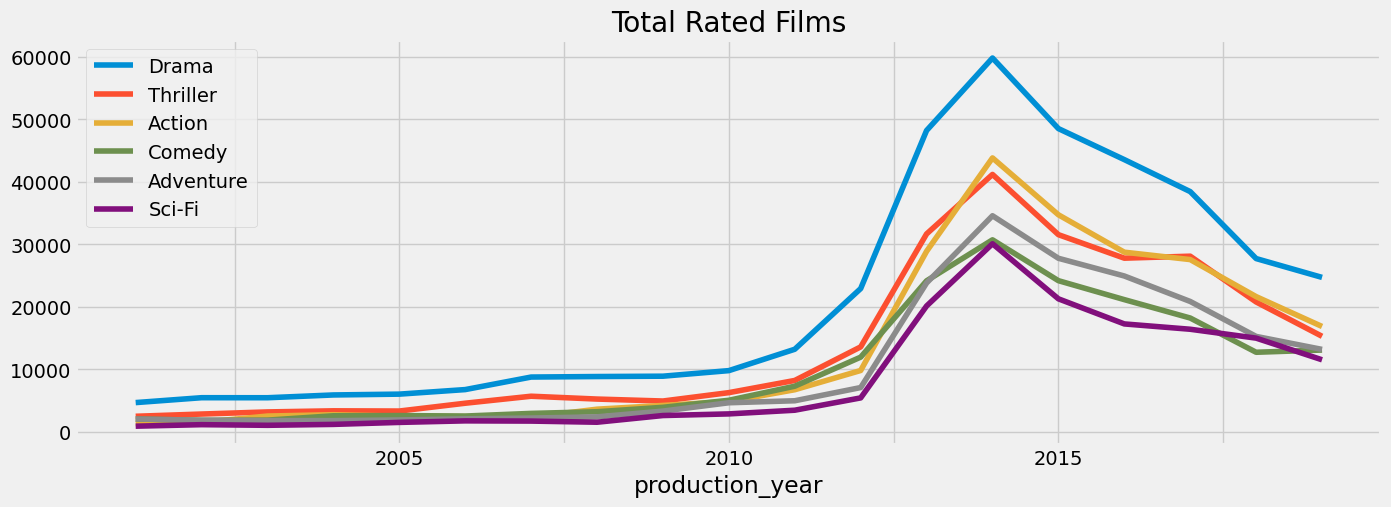

In [33]:
(genre_groups.rolling(2).mean()
 .plot(figsize=(15,5),
       title="Total Rated Films"));

And here is your graph output for this data

This gives a nice visual representation and helps you to interpret the data to answer the question you posed further up. Here are the take-aways that I took from it:

* _Drama_ and _Thriller_ are the winner genres
* Seems that _Sci-Fi_ & _Adventure_ are not as important genres

On the other hand, some patterns can be misleading since we are only looking at the absolute numbers. Therefore, another way to analyze this phenomenon would be to look at the _percentage changes_. This could help your decision-taking if you are, let's say, in the business of online movie streaming.

So let's give that a try and plot the percentage changes:


In [34]:
percent_change = (tidy_movie_ratings.iloc[:, 4:]
                    .groupby("production_year")
                    .sum()
                    .pct_change(periods=2) # 2 years percent change of the volume
                   ).loc["2000":"2019", top6_genre]

:From this filtered data, let's produce a 5-years moving average graph:

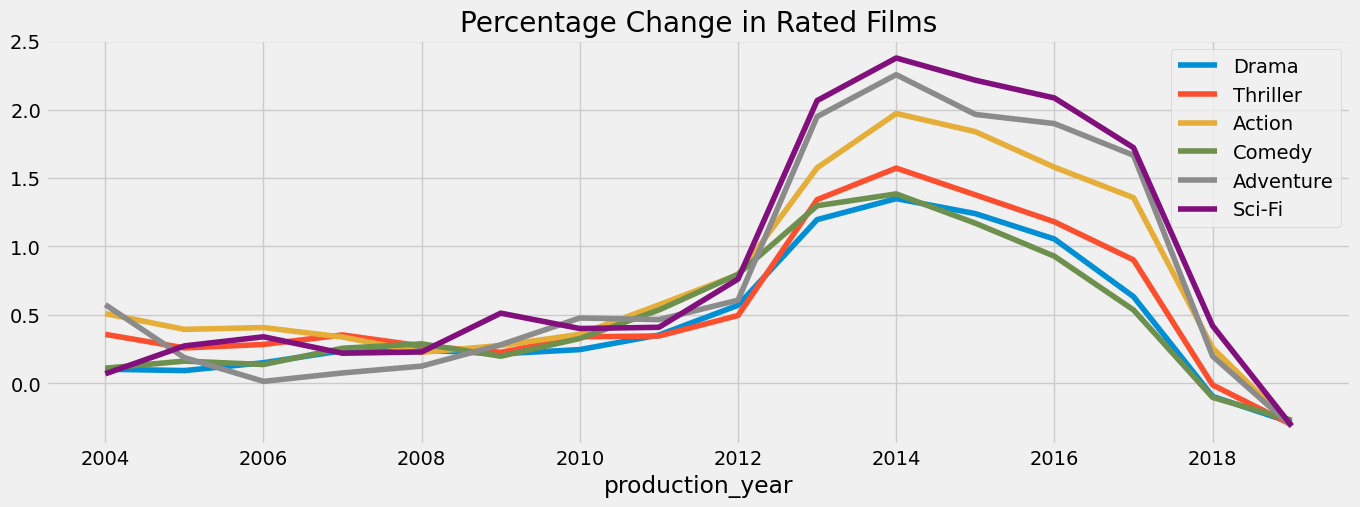

In [35]:
(percent_change.rolling(5).mean() # 5 years moving average
 .plot(figsize=(15,5),
       title="Percentage Change in Rated Films"));

You notice the decline you already spotted earlier one more time. However, it's interesting to see the _Sci-Fi_ & _Adventure_ genres moving to the top.

Indeed, _Sci-Fi_ & _Adventure_ movies were a real _hype_, and you might want to play your cards into them, especially if your business is somewhat related to global film industry trends. These two genres has the sharpest slope for the increase in receiving ratings. This _may_ signal that there is an increasing demand and could be a valuable insight for your business.

Let's stay with one of these hyped genres for a bit longer and explore yet another question you can answer through this data set.

### Top Rated Sci-Fi Movies by Decades

Let's say you're still building out your imaginary streaming service, you understood that the interest in Sci-Fi movies is rising sharply, and you want to make it easy for your users to find the best Sci-Fi movies of all times. What are the movies _from each decade_ which you could suggest to your users by default?

To answer this question, let's start out by writing out the necessary steps first:

- Build a `scifi` base table containing only the columns you need
- Filter for the records before 2020
- Create a new column called `decade`
- Check it out

And here's the code to accomplish these tasks:

In [36]:
cols = ["movie_title", "rating", "production_year", "Sci-Fi", "movie_id"]
condition0 = tidy_movie_ratings["production_year"].astype(int) < 2020
condition1 = tidy_movie_ratings["Sci-Fi"] == 1

scifi = (tidy_movie_ratings
         [cols]
         [condition0 & condition1]
         .drop("Sci-Fi", axis=1)
        )

scifi["decade"] = scifi['production_year'].astype(int)//10*10

The first 5 rows of your new `scifi` data frame will look like this:

In [37]:
scifi.head()

,movie_title,rating,production_year,movie_id,decade
5,Eternal Sunshine of the Spotless Mind,4,2004,338013,2000
8,The Mist,7,2007,884328,2000
11,The Happening,5,2008,949731,2000
14,X-Men: The Last Stand,8,2006,376994,2000
20,Space Milkshake,5,2012,1954843,2010


Next, you will filter for movies that have more than 10 ratings. But how can you find how many times a movie was rated? Here `.groupby()` comes to the rescue.

After getting the counts, you will generate a new list called `movie_list` with the condition that a movie needs to have greater than 10 ratings.

Below, the final operation will be only about getting the indices of the filtered `count_group`. You will achieve that by using `.index.values` method:

In [38]:
count_group = scifi.groupby("movie_id").count()["rating"]

movie_list = count_group[count_group > 10].index.values

The output looks like below:

In [39]:
movie_list[:5]

array([  417, 17136, 21884, 24184, 24216])

`movie_list` now contains those movies that have been rated more than 10 times. Next, you will filter on your `scifi` base table using the `movie_list`.

Notice the usage of the `.isin()` method. It is quite user-friendly and straight-forward:

In [40]:
condition = scifi["movie_id"].isin(movie_list)
columns = ["movie_title", "decade", "rating"]

scifi_filtered = scifi[condition][columns]

After having created the `filtered_scifi` table, you can focus on building up your metrics in order to select the best liked movies of each decade. You will look at the average rating, and you will need to `.groupby()` decade and `movie_title`.

It is important to sort the aggregated value in a _descending_ order to get the results you are expecting. You want each group to have a maximum of 5 films, so a _lambda expression_ can help you to loop through the decade groups and show only the top 5. Otherwise, if there are less than 5 films in a decade, you want to show only the top movie, meaning only 1 record. Finally you will `round` the ratings to two decimal points.

You are encouraged to chop the code shown below into single lines and see the individual result for each of them:

In [41]:
top_rate_by_decade = (scifi_filtered
                     .groupby(["decade", "movie_title"])
                     .mean()
                     .sort_values(["decade", "rating"],
                                                ascending=False)
                     .groupby(level=0, as_index=False)
                     .apply(lambda x: x.head() if len(x) >= 5 else x.head(1))
                     .reset_index(level=0, drop=True)
                    ).round(2)

The output of this operation will be your top-rated _Sci-Fi_ movies by decade:

In [42]:
top_rate_by_decade

rating
decade movie_title                                               
1900   A Trip to the Moon                                    8.48
1920   Metropolis                                            8.73
1930   King Kong                                             8.64
1950   The Day the Earth Stood Still                         8.45
       Forbidden Planet                                      8.40
       Invasion of the Body Snatchers                        8.16
       Kiss Me Deadly                                        8.00
       Creature from the Black Lagoon                        7.91
1960   La jetée                                              8.56
       Planet of the Apes                                    8.28
       The Time Machine                                      8.20
       2001: A Space Odyssey                                 8.11
       Alphaville, une étrange aventure de Lemmy Caution     7.72
1970   Alien                                                 8.47
       Stalker                                               8.36
       Star Wars                                             8.35
       Solaris                                               8.35
       A Clockwork Orange                                    8.34
1980   Back to the Future                                    8.94
       The Return of the Living Dead                         8.71
       Star Wars: Episode V - The Empire Strikes Back        8.66
       Aliens                                                8.64
       E.T. the Extra-Terrestrial                            8.46
1990   Terminator 2: Judgment Day                            9.10
       Gekijô-ban poketto monsutâ - Myûtsû no gyakushû       8.83
       Shin seiki Evangelion Gekijô-ban: Air/Magokoro ...    8.65
       The Matrix                                            8.62
       The Truman Show                                       8.53
2000   Cowboy Bebop: Tengoku no tobira                       9.07
       The Prestige                                          8.88
       WALL·E                                                8.70
       V for Vendetta                                        8.44
       2046                                                  8.40
2010   Avengers: Endgame                                     9.04
       Inception                                             9.02
       Interstellar                                          8.84
       Avengers: Infinity War                                8.76
       Boku no hîrô akademia THE MOVIE ~ 2-ri no eiyû ~      8.62

If you want to see the values starting from 1990, you can do so by slicing the data frame:

In [44]:
# loc method for filtering with the index
top_rate_by_decade.loc[1990:]

rating
decade movie_title                                               
1990   Terminator 2: Judgment Day                            9.10
       Gekijô-ban poketto monsutâ - Myûtsû no gyakushû       8.83
       Shin seiki Evangelion Gekijô-ban: Air/Magokoro ...    8.65
       The Matrix                                            8.62
       The Truman Show                                       8.53
2000   Cowboy Bebop: Tengoku no tobira                       9.07
       The Prestige                                          8.88
       WALL·E                                                8.70
       V for Vendetta                                        8.44
       2046                                                  8.40
2010   Avengers: Endgame                                     9.04
       Inception                                             9.02
       Interstellar                                          8.84
       Avengers: Infinity War                                8.76
       Boku no hîrô akademia THE MOVIE ~ 2-ri no eiyû ~      8.62

**Congratulations** on completing your first _movie recommendation engine_! While some popular online streaming sites famously use _Machine Learning_ to recommend their viewers movies to watch, and that certainly has its use-case, as you can see it can be worth it to first establish some rule-of-thumb recommendations based on data and logic. That's what you now have in these tables you just generated.

What is more, you completed a full data-analysis project:

* You read your data as pandas data frames
* You created basic statistics and interpreted the results
* You joined data frames, applied conditions to filter them, and aggregated them
* You have found patterns by using visualization and developed some hypotheses
* And you didn't jump into conclusions and root causes. You kept your reasoning simple and skeptic
* You created summary tables

All of the above are important and common aspects of working with data.

## What Next?

If you enjoyed this project and you want to learn more and practice your data analysis skills further:

* **Add More Data**: You can search for some additional IMDB data freely available on the internet. Chances are they contain information about _directors_ of the movies. You could join this data with your `tidy_movie_ratings` dataset and see which directors are getting top ratings for which movies over the years, and by decades. This way, you can practice everything you have learned here over again
* **Build Your Service**: You can write a function which takes the `top_rate_by_decade` data frame as input and returns a random movie from the list, further simulating a movie recommendation system
* **Your Idea Here**: There are limitless possibilities to practice and play with this data. Share your explorations with us if you do!
    
I hope you enjoyed this article and continue having fun with analyzing your datasets.

---

>**About the Author:** Cagdas Yetkin is a Data Scientist at Nokia where he works on the next generation Supply Chain improvements for network devices and software. He develops soccer analytics and betting applicatons as a hobby, and enjoys traveling. Connect with him on <a href="https://www.linkedin.com/in/cagdasyetkin/" target="_blank">LinkedIn</a> and <a href="https://twitter.com/cagdasyetkin" target="_blank">Twitter</a>.

_Reviewed by Martin Breuss_

# ...